<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Beatriz_e_Pedro/Trabalho_final_Parte_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalação de pacotes necessários

In [1]:
!pip install efficientnet_pytorch
!pip install transformers
!pip install pytorch-lightning
!pip install sacrebleu
!pip install sentencepiece
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c15fbf694f308d9a06f95823c76b804b92835510dd4fba8050a3591754d4db47
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.6 MB/s 
     |████████████████████████████████| 101 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

#Import das bibliotecas

In [2]:
# Importar todos os pacotes de uma só vez para evitar duplicados ao longo do notebook.
import gzip
import os
import pytorch_lightning as pl
import random
import sacrebleu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import json
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from matplotlib import pyplot as plt
import h5py
from PIL import Image
from tqdm import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(2, 'Tesla T4')

In [55]:
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset MSCOCO

>Usando a versão reduzida com 23k dados nos primeiros testes

In [3]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-07-07 01:43:08--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.004s  

2022-07-07 01:43:08 (67.4 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json’ saved [289777/289777]

--2022-07-07 01:43:08--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.69.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sen

In [4]:
imgs = h5py.File('TRAIN_IMAGES_coco_5_cap_per_img.hdf5', 'r')
imgs.keys()

<KeysViewHDF5 ['images']>

###Mostrando alguns exemplos

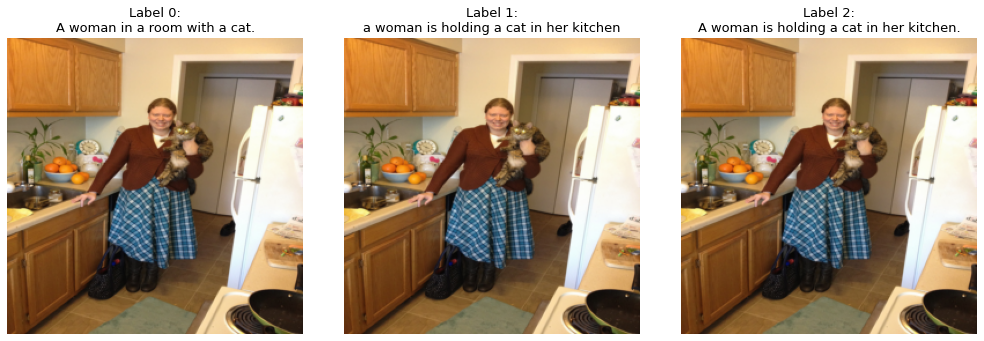

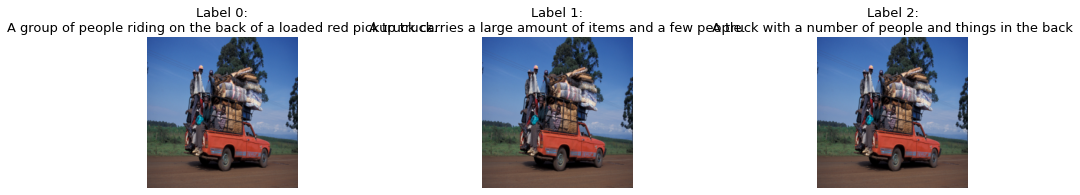

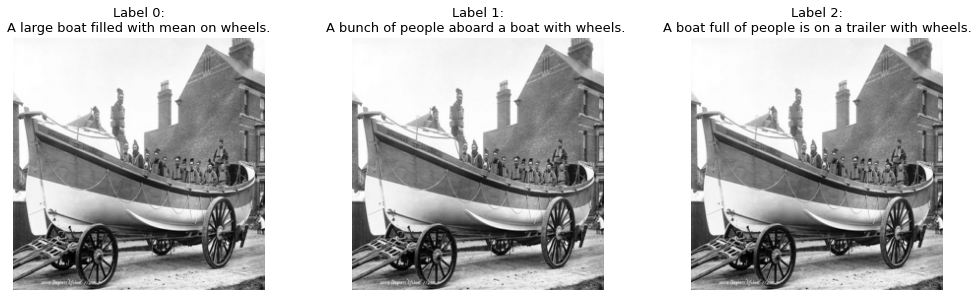

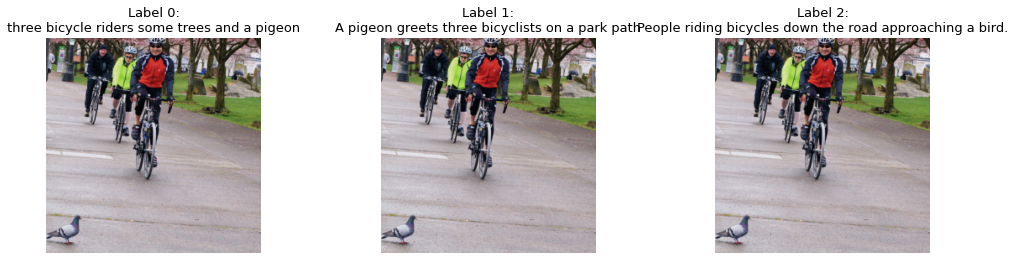

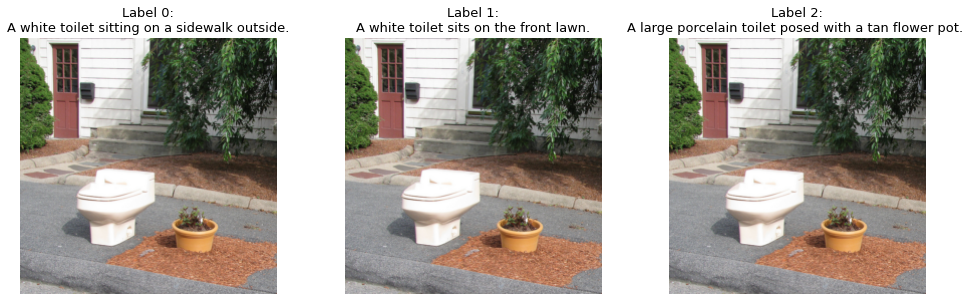

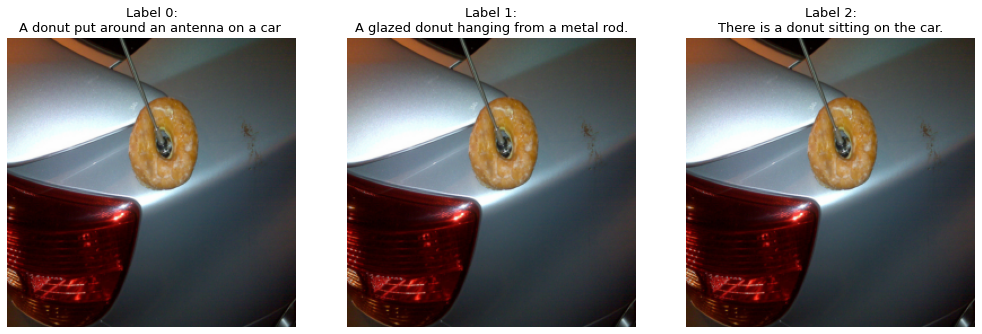

In [5]:
imgs_new = imgs['images']
# print('Types in images'
# '\n')
# print(f'type: {imgs_new.dtype} {type(imgs_new)} {type(imgs_new[0])}\nshape: {imgs_new.shape}'
# '\n')
# print('Types in captions'
# '\n')
# print(f'type: {type(captions)}, {type(captions[0])} len: {len(captions)}, {len(captions[0])}'
# '\n')

for j in range(6):
  img = Image.fromarray(imgs_new[j].transpose(1,2,0))
  # display(img)
  with open('TRAIN_CAPTIONS_coco_5_cap_per_img.json') as json_file:
      captions = json.load(json_file)
  fig, ax = plt.subplots(1, 3, figsize=(14,6))
  for i in range(3):
    ax[i].imshow(img)
    ax[i].set_title(f'Label {i}:'
    '\n'
    f'{captions[j][i]}', fontsize = 13)
    ax[i].axis('off')

  fig.patch.set_alpha(0.5)
  plt.tight_layout()
  plt.show()

#Carregamento dos dados

In [6]:
ENCODER = 'efficientnet-b0'
DECODER = 't5-small'
BATCH_SIZE = 4
NUM_WORKERS = 1

In [7]:
#Para a normalização, usamos a sugerida neste github: https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/README.md

transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])

tokenizer = T5Tokenizer.from_pretrained(DECODER)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [8]:
train_img_path = "./TRAIN_IMAGES_coco_5_cap_per_img.hdf5"
train_label_path = "./TRAIN_CAPTIONS_coco_5_cap_per_img.json"
val_img_path = "./VAL_IMAGES_coco_5_cap_per_img.hdf5"
val_label_path = "./VAL_CAPTIONS_coco_5_cap_per_img.json"
test_img_path = "./TEST_IMAGES_coco_5_cap_per_img.hdf5"
test_label_path = "./TEST_CAPTIONS_coco_5_cap_per_img.json"

train_label = json.load(open(train_label_path))
val_label = json.load(open(val_label_path))
test_label = json.load(open(test_label_path))

In [9]:
class ImageCaptionDataset(Dataset):
    def __init__(self, img_file, captions, img_transform=lambda x: x, text_transform=lambda x: x):
        # We need to defer loading the images as h5py files cant be forked.
        # Ref: https://github.com/pytorch/pytorch/issues/11929
        self.img_file = img_file
        self.captions = captions
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.images = h5py.File(self.img_file, 'r') 

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img = self.images["images"][idx]
        cap = self.captions[idx]
        img = img.astype(float)

        # Normalization.
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])

        return self.img_transform(img), self.text_transform(cap)#, label_token_ids

    def test(self):
        fig, ax = plt.subplots(3, 1, figsize=(8, 16))
        samples = np.random.randint(0, high=self.__len__(), size=3)
        img1, text1 = self.__getitem__(samples[0])
        img2, text2 = self.__getitem__(samples[1])
        img3, text3 = self.__getitem__(samples[2])

        img1 = (np.transpose(img1, (1,2,0)) + 1)/2
        img2 = (np.transpose(img2, (1,2,0)) + 1)/2
        img3 = (np.transpose(img3, (1,2,0)) + 1)/2

        ax[0].imshow(img1)
        ax[0].set_title(f'Label: {text1[0]}')
        # ax[0].set_xlabel(f'Token: {token1}')

        ax[1].imshow(img2)
        ax[1].set_title(f'Label: {text2[0]}')
        # ax[1].set_xlabel(f'Token: {token2}')

        ax[2].imshow(img3)
        ax[2].set_title(f'Label: {text3[0]}')
        # ax[2].set_xlabel(f'Token: {token3}')

        plt.tight_layout()
        plt.show()

In [10]:
trainset = ImageCaptionDataset(train_img_path, train_label, img_transform=transform)
valset = ImageCaptionDataset(val_img_path, val_label, img_transform=transform)
testset = ImageCaptionDataset(test_img_path, test_label, img_transform=transform)

In [11]:
trainset.images['images']

<HDF5 dataset "images": shape (23520, 3, 256, 256), type "|u1">

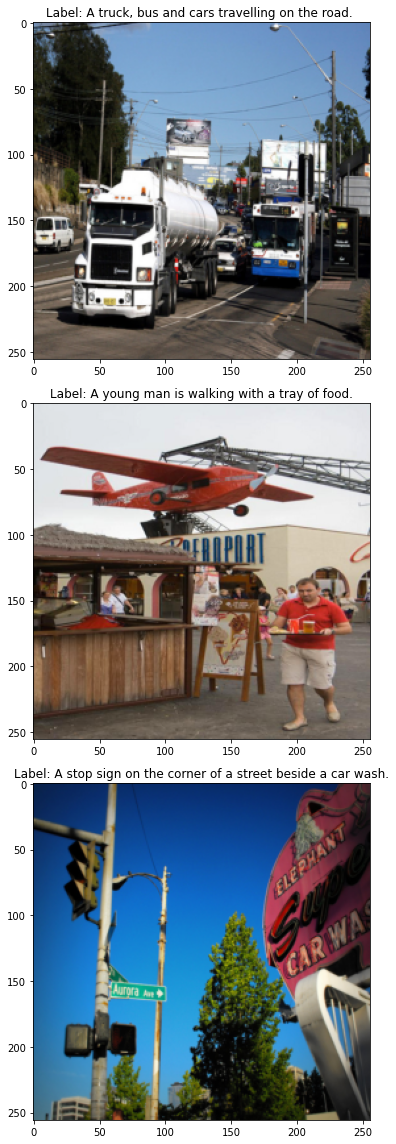

In [12]:
trainset.test()

In [13]:
'''
A função collate_any seleciona um label aleatório dentre os 5 correspondentes a figura,
e uma vez definido o label realiza-ra o tokenização do mesmo de ocordo com o encoded de
T5. Sendo este usado no Dataset de treino
'''

def collate_any(batch):
   
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([random.choice(r[1]) for r in batch])
    
    batch_tokens = tokenizer.batch_encode_plus(
        labels,
        padding="longest",
        return_tensors="pt")['input_ids']

    return imgs, labels, batch_tokens

'''
 Um processo semelhante é aplicado pela collate_all, entretanto neste usa-se
 os 5 labels de cada imagem, passando eles pelo tokenizador. Sendo este metodo
 usado para os datasets de validação e teste.
'''
def collate_all(batch):
  
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = np.array([r[1] for r in batch])

    encoded = [tokenizer.batch_encode_plus(label, 
                                           padding="longest", 
                                           return_tensors='pt')['input_ids']
    for label in labels]
            
    return imgs, labels, encoded

###Criando o dataset

In [14]:
lr = 5e-4
bs = 32
patience = 10
max_epochs = 100
seq_len = 32
# Define hyperparameters
params = {
          'model_name': 't5-small',
          'batch_size': bs,
          'num_workers': os.cpu_count(),
          'learning_rate': lr,
          'max_epochs': max_epochs, 
          'patience': patience,
          'monitor_variable': 'val_bleu_score',
          'seq_len':seq_len
      }
print(params)

{'model_name': 't5-small', 'batch_size': 32, 'num_workers': 2, 'learning_rate': 0.0005, 'max_epochs': 100, 'patience': 10, 'monitor_variable': 'val_bleu_score', 'seq_len': 32}


In [15]:
trainloader = DataLoader(trainset,
                          shuffle=True,
                          batch_size=params['batch_size'],
                          num_workers=params['num_workers'],
                          collate_fn=collate_any)

valloader = DataLoader(valset,
                        batch_size=1,
                        num_workers=params['num_workers'],
                        collate_fn=collate_all)

testloader = DataLoader(testset,
                         num_workers=params['num_workers'],
                         collate_fn=collate_all)

#Criando o modelo

In [16]:
from sacrebleu.metrics import BLEU, CHRF, TER
bleu = BLEU()
chrf = CHRF()

In [17]:
from transformers import AdamW

class EfficientT5(pl.LightningModule):
    def __init__(self, train_dataloader, val_dataloader, test_dataloader, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        # EfficientNet image encoder.
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', advprop=True)

        # Features da efficient net atuarão como as features do encoder do T5
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['model_name'])

        # Patch convolution. Basically tranform the 2D image into 16x16 patches with 2048 dimensions.
        self.bridge = nn.Conv2d(in_channels=112, out_channels=self.decoder.config.d_model, kernel_size=1)
        
        # Convert patches from 2048 to 512 dimensions.
        self.linear = nn.Linear(self.decoder.config.d_ff, self.decoder.config.d_model)

        self.tokenizer = T5Tokenizer.from_pretrained(params['model_name'])
        self.learning_rate = params['learning_rate']


    def forward(self, batch):

        images, labels, tokens = batch

        features = model.encoder.extract_endpoints(images)["reduction_4"]
        features = self.bridge(features)

        efn_embeddings = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_ff)

        # Add a non-linearity (this seems to speed up training a little bit).
        efn_embeddings = F.relu(efn_embeddings)
        
        # Resize to transformer dimension.
        efn_embeddings = self.linear(efn_embeddings)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=tokens,
                                   return_dict=True)
            return outputs.loss
        else:
            max_length = self.params['seq_len']

            # Add start of sequence token
            decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                    self.decoder.config.decoder_start_token_id,
                                    dtype=torch.long).to(efn_embeddings.device)

            encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

            for step in range(max_length-1):
                logits = self.decoder(decoder_input_ids=decoded_ids,
                                      encoder_outputs=encoder_hidden_states)[0]
                next_token_logits = logits[:, -1, :]

                # Greedy decoding
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                
                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                    break

                # Concatenate past ids with new id, keeping batch dimension
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

            return decoded_ids

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu_result = bleu.corpus_score(preds, list(zip(*trues)))
        self.log("val_bleu_1", bleu_result.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu_result.precisions[3], prog_bar=True)

        self.log("val_bleu_score", bleu_result.score, prog_bar=True)


    def test_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))

        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=5e-4)

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

In [18]:
model = EfficientT5(train_dataloader=trainloader,
                    val_dataloader=valloader,
                    test_dataloader=testloader,
                    params=params)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [22]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=2,
                     enable_checkpointing=False, 
                     fast_dev_run=True)

trainer.fit(model)
trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarn

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['A large jetliner sitting on top of an airport runway.'
 'View from gate of jet connected to jet way for passengers to board or deplane'
 'Airline employees by an aircraft parked at the gate'
 'A large white airplane and a person on a lot.'
 'The plane is parked at the gate at the airport terminal.']
Prediction: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1                  0.0
       test_bleu_4                  0.0
     test_bleu_score                0.0
──────────────────────────────────────────────────────────────────────

[{'test_bleu_1': 0.0, 'test_bleu_4': 0.0, 'test_bleu_score': 0.0}]

#Treinamento

In [56]:
logger = pl.loggers.csv_logs.CSVLogger(f"/content/drive/MyDrive/IA_025/Logs", name = 'Image_caption')

early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_bleu_score', patience=params['patience'], mode='max')

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/MyDrive/IA_025/Logs/{epoch}-{val_bleu_socre:.2f}',
                                                   monitor='val_bleu_score')

trainer = pl.Trainer(
    gpus=1,
    max_epochs=params['max_epochs'],
    logger=logger, 
    callbacks=[early_stop_callback],
    checkpoint_callback=checkpoint_callback,
    # Run validation over a smaller sample.
    limit_val_batches=.5,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f99f285a750>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f99f285a750>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(model)

Missing logger folder: /content/drive/MyDrive/IA_025/Logs/Image_caption
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | Conv2d                     | 57.9 K
3 | linear  | Linear                     | 1.0 M 
-------------------------------------------------------
66.9 M    Trainable params
0         Non-trainable params
66.9 M    Total params
267.608   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sample Target: ['Girl in a tank top holding a kitten in her back yard'
 'A young girl is holding a small cat.'
 'A girl smiles as she holds a kitty cat.'
 'Girl with a yellow shirt holding a small cat'
 'A little girl holding a kitten next to a blue fence.']
Prediction: <pad> A man is holding a hotdog in a bun.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Sample Target: ['A gray chair and a black chair sit in a room near a lamp.'
 'A large recliner sitting next to a table.'
 'A cat peek from between two sofa chairs. '
 'A cat is sitting in a recliner chair.'
 'Cat sitting on a maroon couch behind a coffee table.']
Prediction: <pad> A cat sitting on top of a chair in front of a window.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A brown and white dog standing over a bowl of food.'
 'A brown and white dog looking at the camera.'
 'a dog with a plate of food on the ground'
 'A small dog looking up while standing in front of a food dish.'
 'A small dog looking up from his feeding bowl']
Prediction: <pad> A dog laying on a bench with a stuffed animal.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A row of cars parked on a street with parking meters.'
 'A parking meter on a street by a car with traffic.'
 'A series of parking meters and cars are located next to each other. '
 'A row of parked cars sitting next to parking meters.'
 'A parking meter on a street with cars']
Prediction: <pad> A car is parked in front of a building.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Two dogs looking out the opposite windows of a door frame.'
 'a close up of a door with two dogs in the glass of either side of the door'
 'A small dog sitting outside of a window looking in'
 'Two dogs looking out of the glass sidelights of a door'
 'Two small white dogs looking out small windows of a building.']
Prediction: <pad> A window with a window and a window.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat getting some attention on an outdoor bench'
 'A tiger striped cat being petted on a wooden bench.'
 'this tabby cat is loving the attention she is getting from this man'
 'A brown tabby cat is laying on a wood bench.'
 'Cat on wooden bench clawing bench arm being petted.']
Prediction: <pad> A cat is sitting on a wooden bench.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A gray cat lying on top of a stool' 'a tired cat laying down on its bed'
 'A gray cat sitting on a chair looking a little sad. '
 'A gray cat sleeping on top of a woodenchair.'
 'Gray cat lying on a chair looking at the camera.']
Prediction: <pad> A cat laying on a bed with a stuffed animal.



Validation: 0it [00:00, ?it/s]


Sample Target: ['The man in the red tie is putting on his glasses.'
 'A young girl wearing a red tie is adjusting her glasses. '
 "The man wearing a red tie is standing near an animal's plastic house."
 'A person with glasses and a tie in a room.'
 'a woman wearing glasses a shirt and tie']
Prediction: <pad> A man sitting on a couch with a hot dog.



Validation: 0it [00:00, ?it/s]


Sample Target: ['A large blue and white airplane on a lot.'
 'A plane on a runway in an airport'
 'A large jumbo jet on the runway of an airport.'
 'A commercial airplane on a runway at an airport.'
 'The huge four engine airliner is driving on the runway.']
Prediction: <pad> A large jetliner sitting on top of an airport tarmac.



Validation: 0it [00:00, ?it/s]


Sample Target: ['Four birds walking behind each other in the water and a boat out to sea.'
 'There are cranes in the water and a boat in the distance. '
 'some birds with long necks standing in the water '
 'A flock of birds walking along a beach near water.'
 'Several birds walk across the shore as the sun sets.']
Prediction: <pad> A group of birds flying over a beach.



Validation: 0it [00:00, ?it/s]


Sample Target: ['The horse is eating the grass near the fence. '
 'A horse grazes on a beautiful day, and brushes its tail in the wind'
 'A white horse grazing on grass near a fence. '
 'A horse grazes while standing next to a fence. '
 'a large horse eating grass in front of a wooden fence']
Prediction: <pad> A horse standing next to a fence in a grassy field.



Validation: 0it [00:00, ?it/s]


Sample Target: ['THIS IS A PICTURE OF A LOADED HOT DOG'
 'A person holding a hot dog with lots of fixings on it.'
 'Somebody took a bite out of a hot dog. '
 'A person holding a hot dog on a bun.'
 'a hand holding a hot dog wrapped in white paper']
Prediction: <pad> A person holding a hot dog in a bun.



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Meteor Score

In [58]:
full_string = 'As cartas de amor, se há amor, têm de ser ridículas. Mas, afinal, só as criaturas que nunca escreveram cartas de amor é que são ridículas'
tokens = word_tokenize(full_string)

meteors = np.zeros((len(tokens),len(tokens)))

for i in tqdm(range(len(tokens))):
  for j in range(len(tokens)):
    meteors[i,j] = round(meteor_score([tokens[:i]], tokens[:j]), 4)


100%|██████████| 31/31 [00:00<00:00, 126.17it/s]


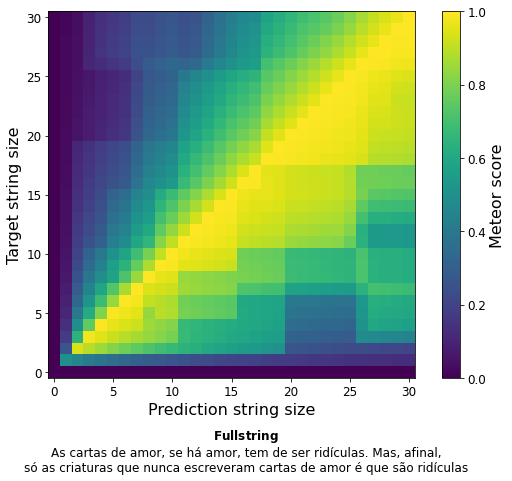

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
cont = plt.imshow(meteors)
plt.ylim(-0.5, len(tokens)-0.5)
plt.xlim(-0.5, len(tokens)-0.5)
cb = plt.colorbar(cont, cmap = 'viridis')
cb.set_label('Meteor score', size=16)
cb.ax.tick_params(labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Prediction string size', fontsize = 16)
plt.ylabel('Target string size', fontsize = 16)
fig.text(0.5,-0.1, r'$\bf{Full string}$'
'\n'
'As cartas de amor, se há amor, tem de ser ridículas. Mas, afinal,'
'\n'
'só as criaturas que nunca escreveram cartas de amor é que são ridículas', ha = 'center',
fontsize = 12)
plt.tight_layout()
plt.savefig('meteor_score.svg', dpi = 300, bbox_inches = 'tight')

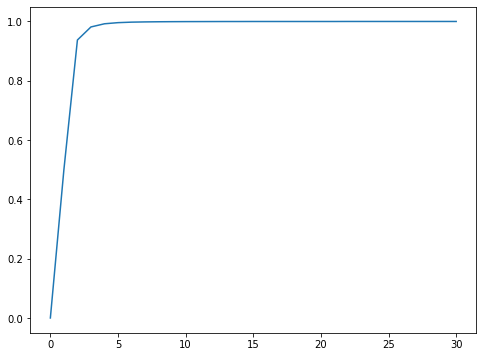

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
cont = plt.plot(np.diag(np.mat(meteors)))

In [61]:
full_string = 'There are three things all wise men fear: the sea in storm, a night with no moon, and the anger of a gentle man.”'
tokens = word_tokenize(full_string)

meteors = np.zeros((len(tokens),len(tokens)))

for i in tqdm(range(len(tokens))):
  for j in range(len(tokens)):
    meteors[i,j] = round(meteor_score([tokens[:i]], tokens[:j]), 4)


100%|██████████| 29/29 [00:00<00:00, 103.69it/s]


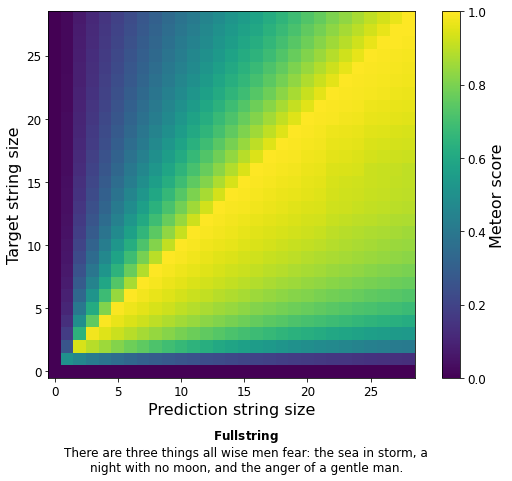

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
cont = plt.imshow(meteors)
plt.ylim(-0.5, len(tokens)-0.5)
plt.xlim(-0.5, len(tokens)-0.5)
cb = plt.colorbar(cont, cmap = 'viridis')
cb.set_label('Meteor score', size=16)
cb.ax.tick_params(labelsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Prediction string size', fontsize = 16)
plt.ylabel('Target string size', fontsize = 16)
fig.text(0.5,-0.1, r'$\bf{Full string}$'
'\n'
'There are three things all wise men fear: the sea in storm, a'
'\n'
'night with no moon, and the anger of a gentle man.', ha = 'center',
fontsize = 12)
plt.tight_layout()
plt.savefig('meteor_score_en.svg', dpi = 300, bbox_inches = 'tight')

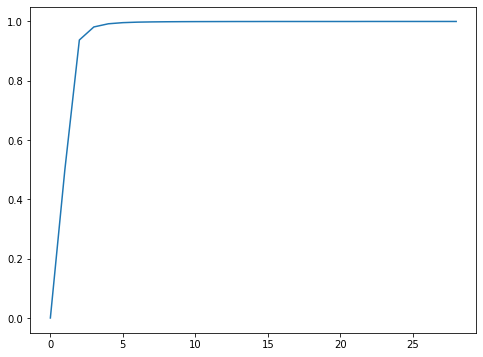

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
cont = plt.plot(np.diag(np.mat(meteors)))

In [64]:
print(meteor_score([word_tokenize('I')],
             word_tokenize('I like')))

print(meteor_score([word_tokenize('I')],
             word_tokenize('I want')))

print(meteor_score([word_tokenize('I like')],
             word_tokenize('I')))

print(meteor_score([word_tokenize('I like')],
             word_tokenize('I like')))

print(meteor_score([word_tokenize('The')],
             word_tokenize('The')))

0.45454545454545453
0.45454545454545453
0.2631578947368421
0.9375
0.5


#Teste

In [65]:
model.eval()

trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Sample Target: ['A pair of horses graze in a field with trees.'
 'Two brown horses grazing the grass in a field. '
 'Two large brown horses grazing in a lush field of grass.'
 'Two large horses grazing in a large field.'
 'Horse greases in an open field on green grass ']
Prediction: <pad> A horse grazing in a field with a tree in the background.

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           54.53629684448242
       test_bleu_4           4.544681072235107
     test_bleu_score        16.065364837646484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 54.53629684448242,
  'test_bleu_4': 4.544681072235107,
  'test_bleu_score': 16.065364837646484}]

In [67]:
test_loader = DataLoader(testset, batch_size = 1, collate_fn = collate_all)
meteors = []

for batch, i in zip(test_loader, range(len(test_loader))):
  images, labels, tokens = batch
  model.eval()
  model.cpu()
  pred_tokens = model(batch)
  decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]
  labels_tokenized = []
  for j in range(5):
    labels_tokenized.append(word_tokenize(labels[0][j]))
  # print(decoded_preds)
  # print(labels)
  meteors.append(meteor_score(labels_tokenized, word_tokenize(decoded_preds[0])))

print('\n'
f'Average meteor score in test set: {np.mean(meteors)} +/- {np.std(meteors)}'
'\n'
f'Max meteor: {np.max(meteors)}'
'\n'
f'Min meteor: {np.min(meteors)}')


Average meteor score in test set: 0.4417422757268479 +/- 0.1634313218779882
Max meteor: 0.9703883495145632
Min meteor: 0.09803921568627452


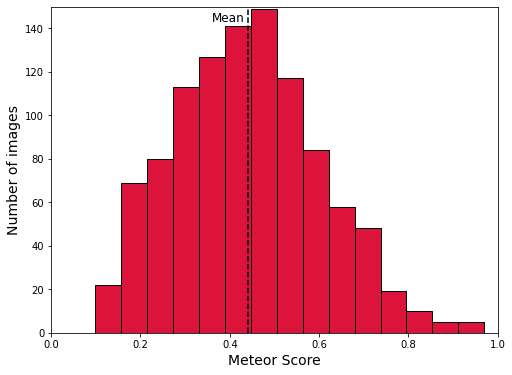

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(meteors, bins = 15, edgecolor='black', color = 'crimson')
plt.xlabel('Meteor Score', fontsize = 14)
plt.ylabel('Number of images', fontsize = 14)
plt.axvline(np.mean(meteors), ls = '--', color = 'black')
plt.text(np.mean(meteors)*0.98, 143, 'Mean', ha = 'right', fontsize = 12)
plt.ylim(0, 150)
plt.xlim(0, 1)
plt.show()

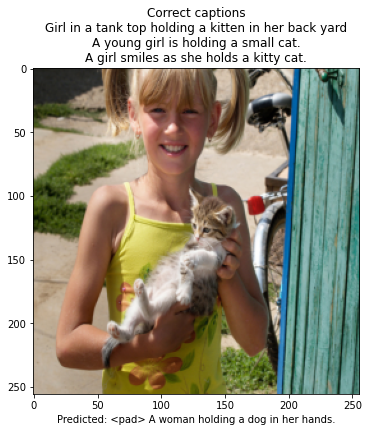

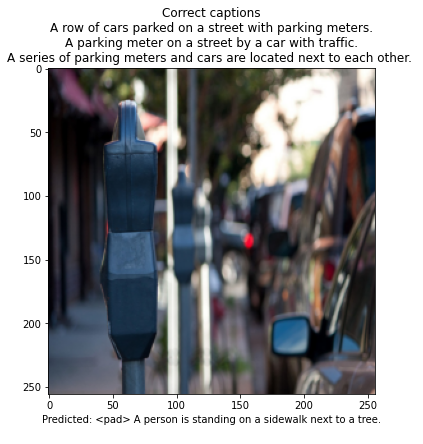

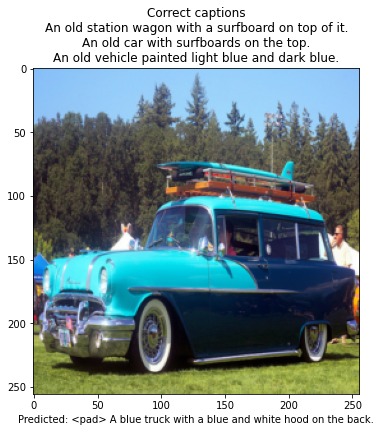

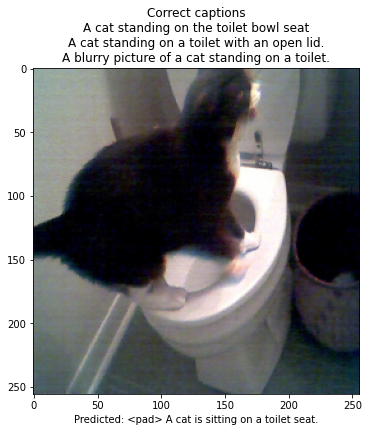

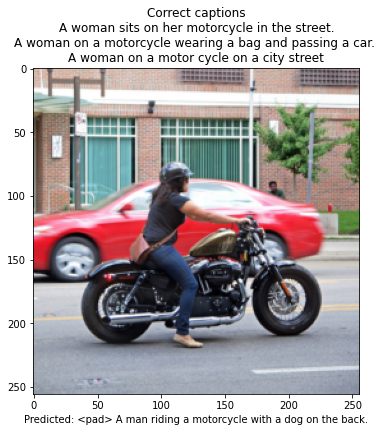

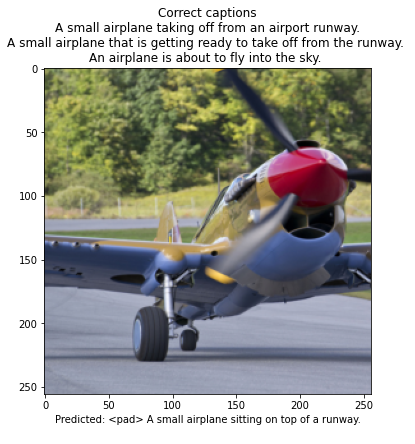

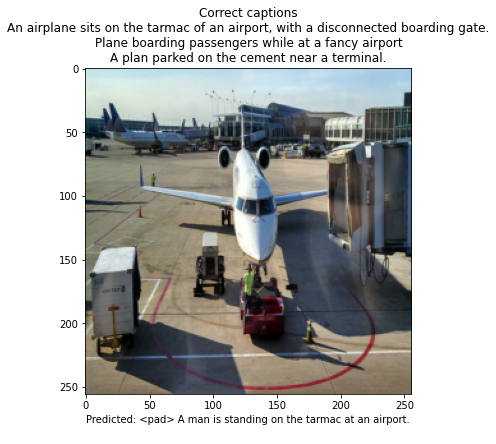

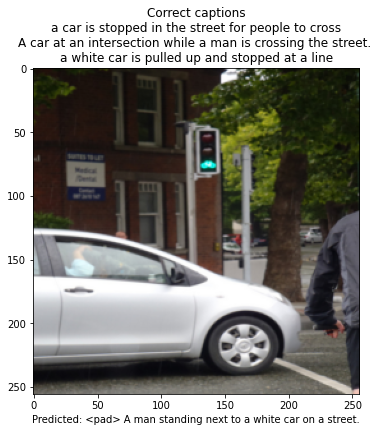

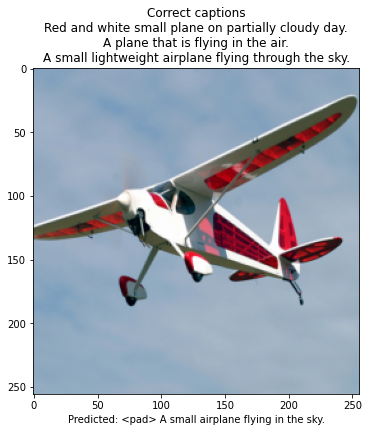

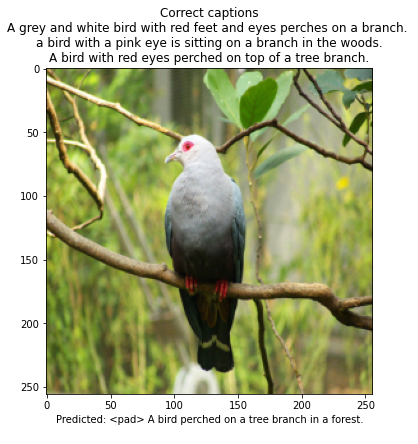

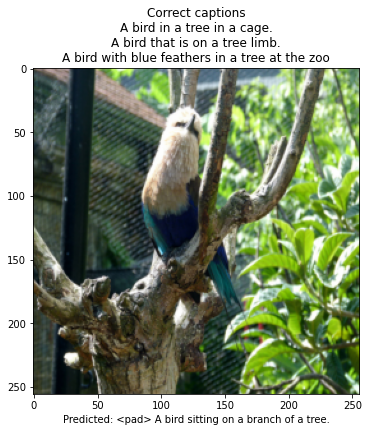

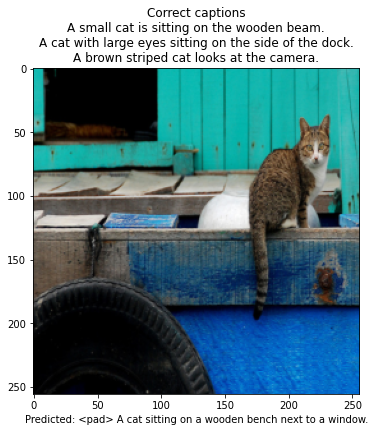

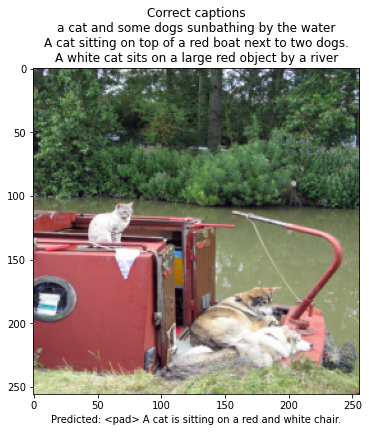

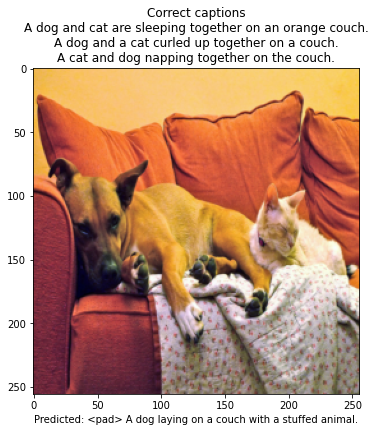

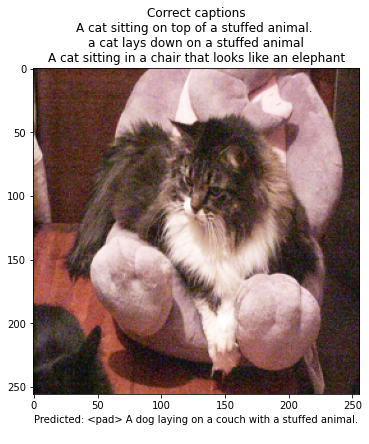

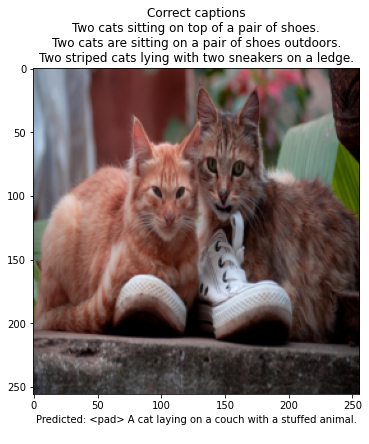

In [69]:
import cv2

val_loader = DataLoader(valset, batch_size=1, collate_fn=collate_all)

for batch, i in zip(val_loader, range(16)):
        
    images, labels, tokens = batch

    model.eval()
    model.cpu()

    pred_tokens = model(batch)

    decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

    for image, label, pred in zip(images, labels, decoded_preds):
        plt.figure(figsize=(8,6))
        plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
        plt.title(f'Correct captions'
        '\n'
        f'{label[0]}'
        '\n'
        f'{label[1]}'
        '\n'
        f'{label[2]}')
        plt.xlabel(f'Predicted: {pred}'
        '\n')
        plt.show()